# <a id='toc1_'></a>[Projet 3 - Préparez des données pour un organisme de santé publique](#toc0_)

**Table of contents**<a id='toc0_'></a>    
- [Projet 3 - Préparez des données pour un organisme de santé publique](#toc1_)    
  - [Contexte projet & Objectifs](#toc1_1_)    
    - [Installation & Imports des librairies](#toc1_1_1_)    
  - [Creations des fonctions utilitaires](#toc1_2_)    
    - [Valeurs manquantes, inutilles ou dupliqué](#toc1_2_1_)    
    - [Valeurs aberantes](#toc1_2_2_)    
    - [Fonctions de visualisations des graphiques](#toc1_2_3_)    
    - [Fonction generale pour gerer le rendu des graphiques](#toc1_2_4_)    
  - [Analyses & Manipulations des données](#toc1_3_)    
    - [Lecture du dataframe](#toc1_3_1_)    
    - [Etape 1 - Nettoyez et filtrez des features et produits](#toc1_3_2_)    
    - [Explication des variables restantes](#toc1_3_3_)    
      - [🍏 Valeurs nutritionnelles](#toc1_3_3_1_)    
      - [🏅 Scores et Étiquettes](#toc1_3_3_2_)    
    - [Etape 2 & 3 - Identifiez et traitez les valeurs aberrantes & Imputations de valeurs manquantes](#toc1_3_4_)    
    - [Etape 4 - Analyse uni/bi  variée](#toc1_3_5_)    
      - [Pie Chart](#toc1_3_5_1_)    
      - [Pairplot](#toc1_3_5_2_)    
      - [Matrice de correlation](#toc1_3_5_3_)    
  - [Analyse en composante principale (PCA)](#toc1_4_)    
    - [Scree plot](#toc1_4_1_)    
    - [Cercle des correlation](#toc1_4_2_)    
    - [Interpretation des resultats](#toc1_4_3_)    
  - [ANOVA](#toc1_5_)    
    - [Calcul de l'anova](#toc1_5_1_)    
    - [Plot de l'anova](#toc1_5_2_)    
    - [Interpretation des resultats](#toc1_5_3_)    
  - [Respect des RGPD](#toc1_6_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## <a id='toc1_1_'></a>[Contexte projet & Objectifs](#toc0_)

Contexte :
L'objectif est d'améliorer la base de données Open Food Facts, qui recueille des informations sur les produits alimentaires du marché. Cette base de données est utilisée par un organisme de santé publique pour analyser les habitudes alimentaires de la population et prendre des décisions éclairées.


Problématique :
La base de données Open Food Facts présente des problèmes de qualité et de complétude des données. Il est nécessaire de nettoyer les données, de traiter les valeurs manquantes et aberrantes, et de réaliser des analyses pour évaluer la faisabilité du projet.

### <a id='toc1_1_1_'></a>[Installation & Imports des librairies](#toc0_)

In [ ]:
# Installation des libs
# %pip install pandas numpy scikit-learn matplotlib seaborn
# %pip install skimpy
# %pip install missingno
# %pip install scipy
# %pip install feature-engine
# %pip install plotly
# %pip install mlxtend

In [ ]:
# Import des librairies
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from skimpy import skim
import missingno as msno
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

from sklearn.preprocessing import StandardScaler
from feature_engine.imputation import CategoricalImputer
from feature_engine.imputation import MeanMedianImputer
from mlxtend.plotting import plot_pca_correlation_graph
from sklearn.experimental import enable_iterative_imputer

from sklearn.impute import IterativeImputer
%matplotlib inline

## <a id='toc1_2_'></a>[Creations des fonctions utilitaires](#toc0_)

### <a id='toc1_2_1_'></a>[Valeurs manquantes, inutilles ou dupliqué](#toc0_)

In [ ]:
def delete_useless_duplicate_and_missing_columns(data, useless_columns, threshold,):
    """Deletes columns with more than threshold% of missing values and generates a bar plot showing the remaining columns in the new dataframe.

    Args:
        data (pd.Dataframe): Any dataframe you want to process
        useless_columns(list): A list with all the columns you want to delete
        threshold (int): Threshold percentage of missing values above which columns are deleted

    Returns:
        data (pd.Dataframe):The dataframe with columns removed if they have more than threshold% missing values
    """
    # Calculer le pourcentage de valeurs manquantes pour chaque colonne
    missing_percent = data.isnull().mean() * 100

    # Filtrer les colonnes qui ont plus de threshold% de valeurs manquantes
    cols_with_many_missing = missing_percent[missing_percent > threshold].index
    print(f"Colonnes avec plus de {threshold}% de valeurs manquantes : {len(cols_with_many_missing)}")

    # Supression des colonnes
    data = data.drop(columns = [*cols_with_many_missing , *useless_columns])
    print(f"Colonnes restante apres traitement: {data.shape[1]}")

    # Supression des doublons
    data = data.drop_duplicates()
    return data


### <a id='toc1_2_2_'></a>[Valeurs aberantes](#toc0_)

In [ ]:
def identify_and_replace_outliers(data):
    """Identify and replace outliers in the DataFrame.

    This function identifies outliers based on the IQR method and replaces them with NaN.
    It then imputes missing values using KNN for columns with more than 20% missing values
    and uses the median for columns with less than or equal to 20% missing values. Finaly 
    we input categorical data with unknow value.

    Args:
        data (pd.DataFrame): The DataFrame to process.

    Returns:
        pd.DataFrame: The DataFrame with outliers replaced and missing values imputed.
    """
    
    # Get numerical columns
    numerical_columns = list(data.select_dtypes(include="number").columns)

    # Calculate the quartiles
    Q1 = data[numerical_columns].quantile(0.25)
    Q3 = data[numerical_columns].quantile(0.75)

    # Calculate the IQR
    IQR = Q3 - Q1

    # Define bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Replace outlier values with NaN
    data[(data[numerical_columns] < lower_bound) | (data[numerical_columns] > upper_bound)] = np.NaN


    # Calculate the percentage of missing values for each column
    missing_percentage = data[numerical_columns].isnull().mean()

    # Columns to impute with KNN (more than 20% missing values)
    columns_knn = missing_percentage[missing_percentage > 0.2].index.tolist()

    # Columns to impute with the median (less than or equal to 20% missing values)
    columns_median = missing_percentage[missing_percentage <= 0.2].index.tolist()

    # Initialize & apply KNN imputer
    imputer = IterativeImputer()
    data[columns_knn] = imputer.fit_transform(data[columns_knn])

    # Replace with the median
    data[columns_median] = data[columns_median].fillna(data[columns_median].median())

    # Handle categorical columns
    categorical_columns = list(data.select_dtypes(include='object').columns)

    # Replace NaN with 'Unknown'
    data[categorical_columns] = data[categorical_columns].fillna('Unknown')

    return data


### <a id='toc1_2_3_'></a>[Fonctions de visualisations des graphiques](#toc0_)

In [ ]:

def render_boxplot(data, title, log_scale=False):
    """Render a box plot of the given DataFrame.

    Args:
        data (pd.DataFrame): The data to visualize, with numerical columns.
        title (str): The title of the plot.
        log_scale (bool, optional): If True, use logarithmic scale for y-axis. Defaults to False.
    
    Returns:
        plt.Axes: The Axes object containing the plot.
    """
    
    # Recuperer les variables numeriques
    numerical_columns = data.select_dtypes(include='number').columns
    
    # Cree le plot
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=data[numerical_columns])

    if not title:
        title = ''
    plt.title(title)
    
    # Set y-axis en echelle log si True
    if log_scale:
        plt.yscale('log')

    plt.tick_params(axis='x', rotation=90)
    plt.tight_layout()
    plt.show()



def render_heatmap_missing_value(data, title):
    if not title:
        title = 'Heatmap des valeurs manquantes'
        # Faire une Heatmap des valeurs manquantes
        plt.figure(figsize=(12, 8))
        sns.heatmap(data.sample(10_000).isnull(), cmap='plasma', cbar=False, yticklabels=False)
        plt.title(title, fontsize=16)
        plt.show()


def render_correlation_matrix(data, title):
    if not title:
        title = 'Matrice de correlation'
        # Lister les colonnes numerique
        numerical_columns = list(df.select_dtypes(include="number").columns)
        some_array = df[numerical_columns].corr()
        sns.heatmap(some_array, cmap='viridis', annot=True, fmt=".1f")
        plt.title(title, fontsize=16)
        plt.show()

def render_piechart(data, col, title):
    pie_chart_values = data[col].value_counts()
    sns.set_style("whitegrid")
    plt.figure(figsize=(6,6))
    plt.pie(pie_chart_values, labels=pie_chart_values.index, autopct='%1.1f%%')
    plt.title(title)
    plt.show()


def render_pca(data, cols, dimensions):
    figure, correlation_matrix = plot_pca_correlation_graph(data[cols].sample(100_00),                                                         
                                                        cols,
                                                        dimensions=dimensions,
                                                        figure_axis_size=10)
    
def render_anova(df, x, y, title):
    # Étape 3 : Tracer le boxplot
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df, x=x, y=y)

    # # Étape 4 : Ajouter les lignes min et max pour chaque groupe
    # for i, group in enumerate(groups):
    #     min_value = np.min(group)
    #     max_value = np.max(group)
    #     plt.plot([i - 0.2, i + 0.2], [min_value, min_value], color='red', linestyle='--', label='Min' if i == 0 else "")
    #     plt.plot([i - 0.2, i + 0.2], [max_value, max_value], color='blue', linestyle='--', label='Max' if i == 0 else "")

    # Ajouter des titres et labels
    plt.title(title)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.legend()
    plt.grid(True)
    plt.show()

### <a id='toc1_2_4_'></a>[Fonction generale pour gerer le rendu des graphiques](#toc0_)

In [ ]:
def generate_graph(data, graph_type ,title=None, log_scale=False, col='nutrition_grade_fr', cols=[], dimensions=(1,2), x='nutrition_grade_fr',  y='energy_100g' ):

    # boxplot
    if graph_type == 'boxplot':
        render_boxplot(data, title, log_scale)

    # Heatmap des valeurs manquantes
    if graph_type == 'heatmap':
        render_heatmap_missing_value(data, title)
    
    # Barchart des valeurs manquantes
    if graph_type == 'msno bar':
        msno.bar(data, log=log_scale)

    # Correlation matix
    if graph_type == 'corr':
        render_correlation_matrix(data, title)
    
    if graph_type == 'pie':
        render_piechart(data, col, title)
    
    if graph_type == 'pca':
        render_pca(data, cols, dimensions)
    
    if graph_type == 'anova':
        render_anova(df, x, y, title)
        

## <a id='toc1_3_'></a>[Analyses & Manipulations des données](#toc0_)

### <a id='toc1_3_1_'></a>[Lecture du dataframe](#toc0_)

In [ ]:
# Lecture du dataframe
df_origin = pd.read_csv('openfoodfacts_dataset.csv', sep='\t')

# Faire une copie du dataframe pour garder le dataframe original intact de toute modification
df = df_origin.copy()
df.describe()

C:\Users\vuill\AppData\Local\Temp\ipykernel_6912\1038874156.py:2: DtypeWarning: Columns (0,3,5,19,20,24,25,26,27,28,35,36,37,38,39,48) have mixed types. Specify dtype option on import or set low_memory=False.
  df_origin = pd.read_csv('openfoodfacts_dataset.csv', sep='\t')


no_nutriments    additives_n  ingredients_from_palm_oil_n  \
count            0.0  248939.000000                248939.000000   
mean             NaN       1.936024                     0.019659   
std              NaN       2.502019                     0.140524   
min              NaN       0.000000                     0.000000   
25%              NaN       0.000000                     0.000000   
50%              NaN       1.000000                     0.000000   
75%              NaN       3.000000                     0.000000   
max              NaN      31.000000                     2.000000   

       ingredients_from_palm_oil  ingredients_that_may_be_from_palm_oil_n  \
count                        0.0                            248939.000000   
mean                         NaN                                 0.055246   
std                          NaN                                 0.269207   
min                          NaN                                 0.000000   
25%                          NaN                                 0.000000   
50%                          NaN                                 0.000000   
75%                          NaN                                 0.000000   
max                          NaN                                 6.000000   

       ingredients_that_may_be_from_palm_oil  nutrition_grade_uk  \
count                                    0.0                 0.0   
mean                                     NaN                 NaN   
std                                      NaN                 NaN   
min                                      NaN                 NaN   
25%                                      NaN                 NaN   
50%                                      NaN                 NaN   
75%                                      NaN                 NaN   
max                                      NaN                 NaN   

        energy_100g  energy-from-fat_100g       fat_100g  ...    ph_100g  \
count  2.611130e+05            857.000000  243891.000000  ...  49.000000   
mean   1.141915e+03            585.501214      12.730379  ...   6.425698   
std    6.447154e+03            712.809943      17.578747  ...   2.047841   
min    0.000000e+00              0.000000       0.000000  ...   0.000000   
25%    3.770000e+02             49.400000       0.000000  ...   6.300000   
50%    1.100000e+03            300.000000       5.000000  ...   7.200000   
75%    1.674000e+03            898.000000      20.000000  ...   7.400000   
max    3.251373e+06           3830.000000     714.290000  ...   8.400000   

       fruits-vegetables-nuts_100g  collagen-meat-protein-ratio_100g  \
count                  3036.000000                        165.000000   
mean                     31.458587                         15.412121   
std                      31.967918                          3.753028   
min                       0.000000                          8.000000   
25%                       0.000000                         12.000000   
50%                      23.000000                         15.000000   
75%                      51.000000                         15.000000   
max                     100.000000                         25.000000   

       cocoa_100g  chlorophyl_100g  carbon-footprint_100g  \
count  948.000000              0.0             268.000000   
mean    49.547785              NaN             341.700764   
std     18.757932              NaN             425.211439   
min      6.000000              NaN               0.000000   
25%     32.000000              NaN              98.750000   
50%     50.000000              NaN             195.750000   
75%     64.250000              NaN             383.200000   
max    100.000000              NaN            2842.000000   

       nutrition-score-fr_100g  nutrition-score-uk_100g  glycemic-index_100g  \
count            221210.000000            221210.000000                  0.0   
mean                  9.165535             

Verifions si les données indiqué par le .describe sont coherante en nous basant sur les données du site openfactfood

| **Colonne**                           | **Moyenne Observée** | **Unité**      | **Valeur Moyenne Tolérée** |
|---------------------------------------|----------------------|----------------|----------------------------|
| energy_100g                           | 1141,92              | kJ             | 800 à 2500                 |
| energy_100g                           | 272,92               | kcal           | 200 à 600                  |
| fat_100g                              | 12,73                | g              | 0 à 20                     |
| saturated-fat_100g                    | 5,13                 | g              | 0 à 10                     |
| carbohydrates_100g                    | 32,07                | g              | 10 à 60                    |
| sugars_100g                           | 16,00                | g              | 0 à 30                     |
| fiber_100g                            | 2,86                 | g              | 2 à 10                     |
| proteins_100g                         | 7,08                 | g              | 5 à 25                     |
| salt_100g                             | 2,03                 | g              | 0 à 5                      |
| sodium_100g                           | 0,80                 | g              | 0 à 2                      |
| nutrition-score-fr_100g               | 9,17                 | score          | -15 à 40                   |
| nutrition-score-uk_100g               | 9,06                 | score          | -15 à 40                   |


### <a id='toc1_3_2_'></a>[Etape 1 - Nettoyez et filtrez des features et produits](#toc0_)

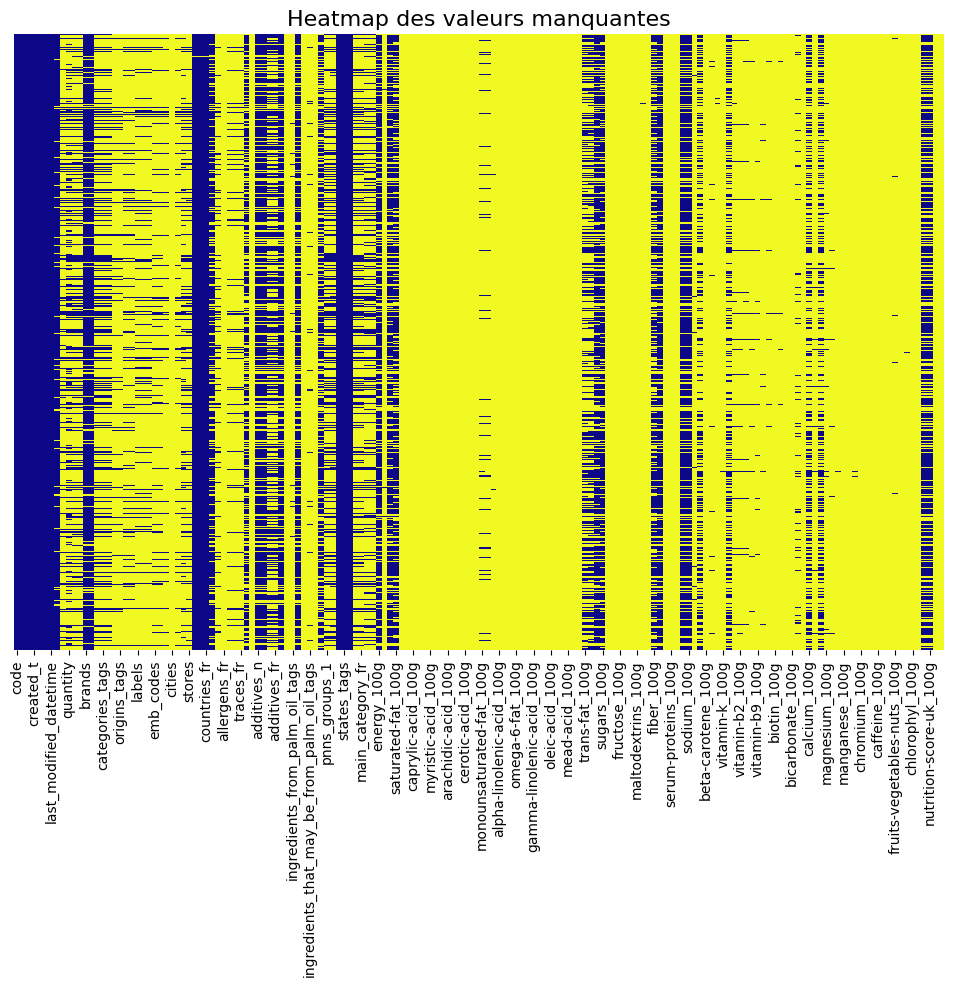

In [ ]:
# Affichages des valeurs manquantes
generate_graph(df, 'heatmap')

In [9]:
useless_columns = [
                    'code', 
                    'url', 
                    'creator', 
                    'created_t', 
                    'created_datetime',
                    'last_modified_t', 
                    'last_modified_datetime', 
                    'quantity',
                    'nutrition-score-uk_100g',
                    'countries',
                    'countries_tags',
                    'countries_fr',
                    'ingredients_text',
                    'serving_size',
                    'brands',
                    'brands_tags',
                    'states',
                    'states_fr',
                    'states_tags',
                    'ingredients_from_palm_oil_n',
                    'ingredients_that_may_be_from_palm_oil_n',
                    'additives',                            
                    ]

# Supression des colonnes inutiles, doubles ou avec trop de valeurs manquantes
df = delete_useless_duplicate_and_missing_columns(data=df, useless_columns=useless_columns, threshold=50)

Colonnes avec plus de 50% de valeurs manquantes : 128
Colonnes restante apres traitement: 13


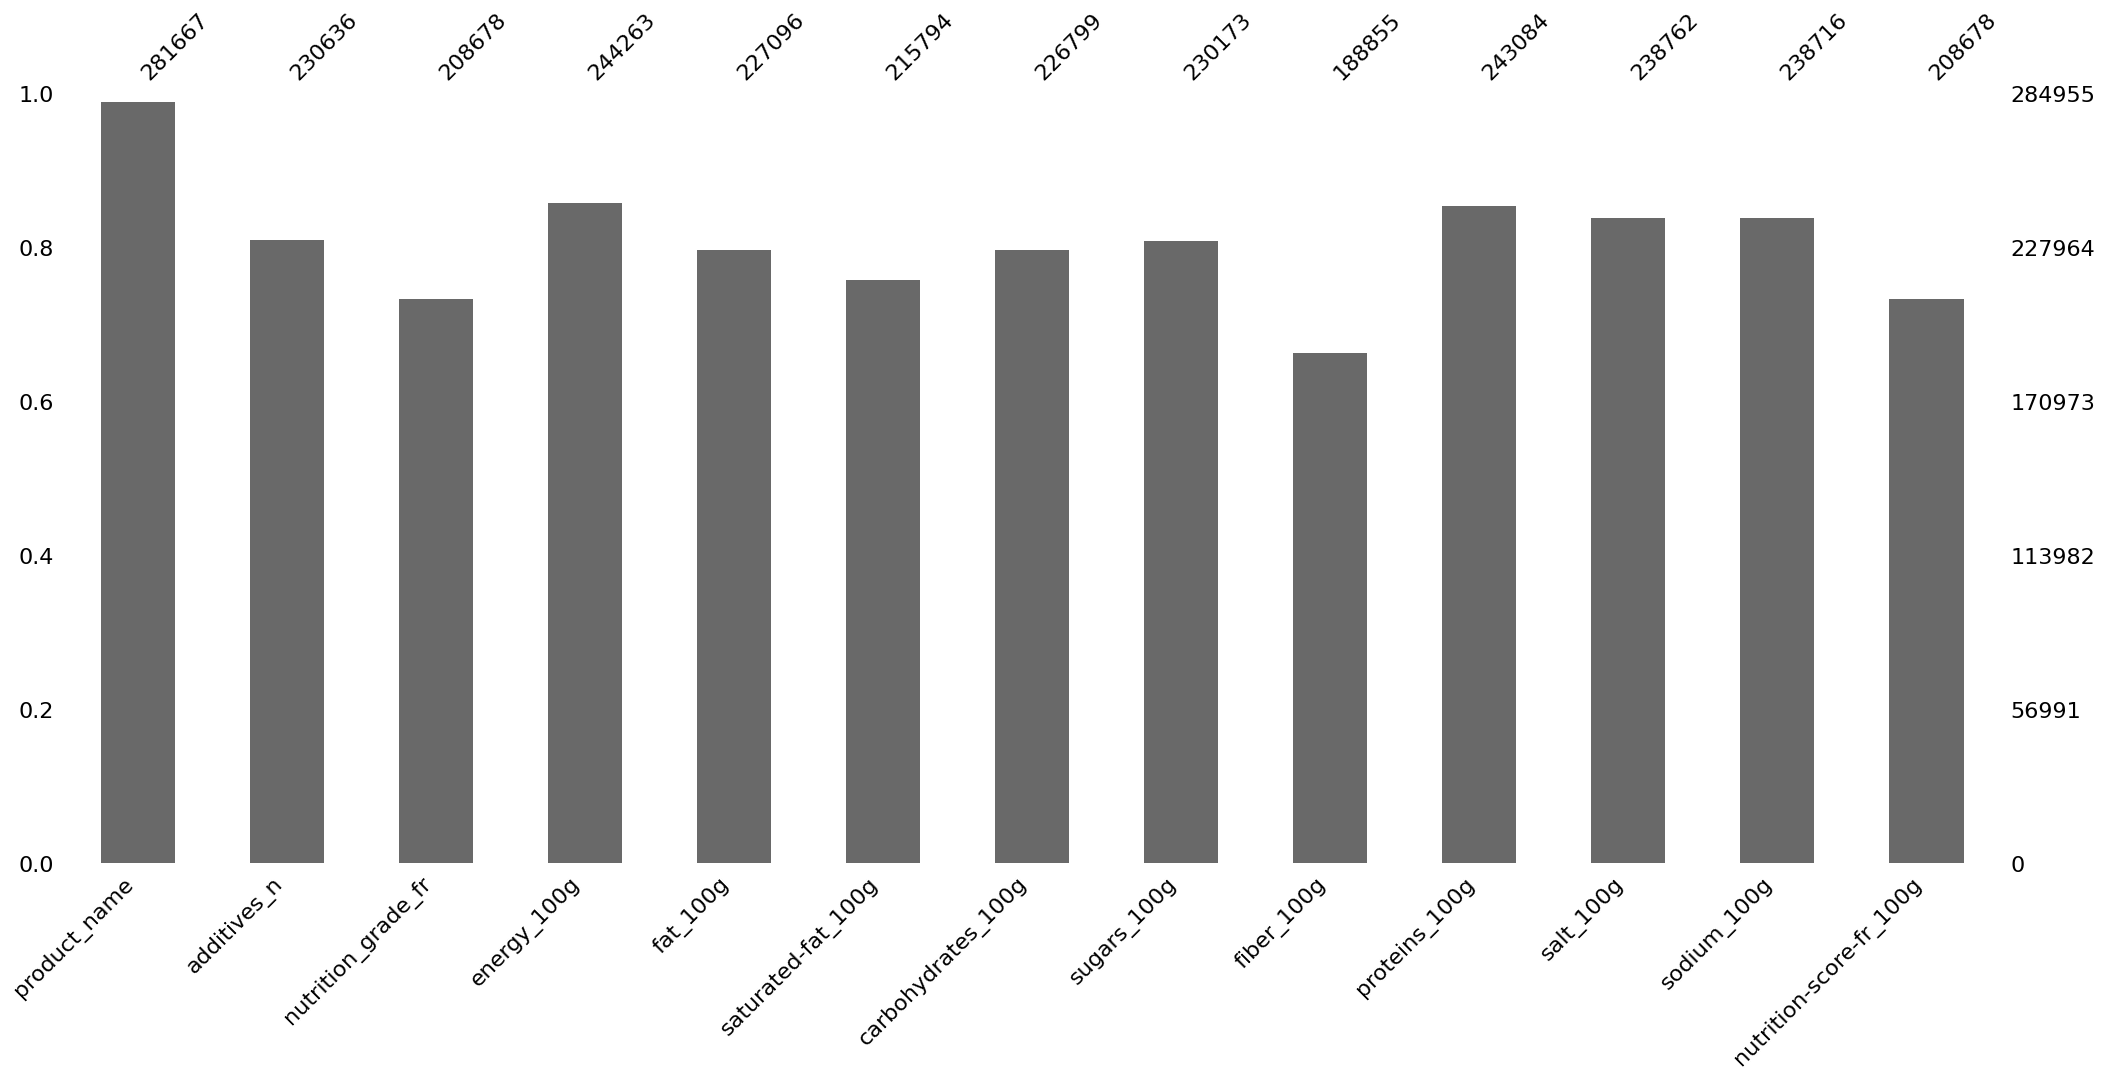

In [ ]:
generate_graph(df, 'msno bar')

### <a id='toc1_3_3_'></a>[Explication des variables restantes](#toc0_)

#### <a id='toc1_3_3_1_'></a>[🍏 Valeurs nutritionnelles](#toc0_)
| Variable               | Description                                                                                          |
|------------------------|------------------------------------------------------------------------------------------------------|
| **energy_100g**        | L'énergie (en kilojoules) contenue dans 100 grammes du produit.                                      |
| **fat_100g**           | La quantité de graisses (en grammes) contenue dans 100 grammes du produit.                          |
| **saturated-fat_100g** | La quantité de graisses saturées (en grammes) contenue dans 100 grammes du produit.                 |
| **carbohydrates_100g** | La quantité de glucides (en grammes) contenue dans 100 grammes du produit.                          |
| **sugars_100g**        | La quantité de sucres (en grammes) contenue dans 100 grammes du produit.                            |
| **fiber_100g**         | La quantité de fibres alimentaires (en grammes) contenue dans 100 grammes du produit.               |
| **proteins_100g**      | La quantité de protéines (en grammes) contenue dans 100 grammes du produit.                         |
| **salt_100g**          | La quantité de sel (en grammes) contenue dans 100 grammes du produit.                               |
| **sodium_100g**        | La quantité de sodium (en grammes) contenue dans 100 grammes du produit.                            |
| **energy_kcal**        | L'énergie (en kilocalories) contenue dans 100 grammes du produit.                                   |


#### <a id='toc1_3_3_2_'></a>[🏅 Scores et Étiquettes](#toc0_)
| Variable               | Description                                                                                          |
|------------------------|------------------------------------------------------------------------------------------------------|
| **nutrition_grade_fr** | La note nutritionnelle du produit, souvent exprimée sous forme de lettre, en français.               |
| **nutrition-score-fr_100g** | Le score nutritionnel du produit pour le marché français, basé sur des critères de santé.           |


### <a id='toc1_3_4_'></a>[Etape 2 & 3 - Identifiez et traitez les valeurs aberrantes & Imputations de valeurs manquantes](#toc0_)

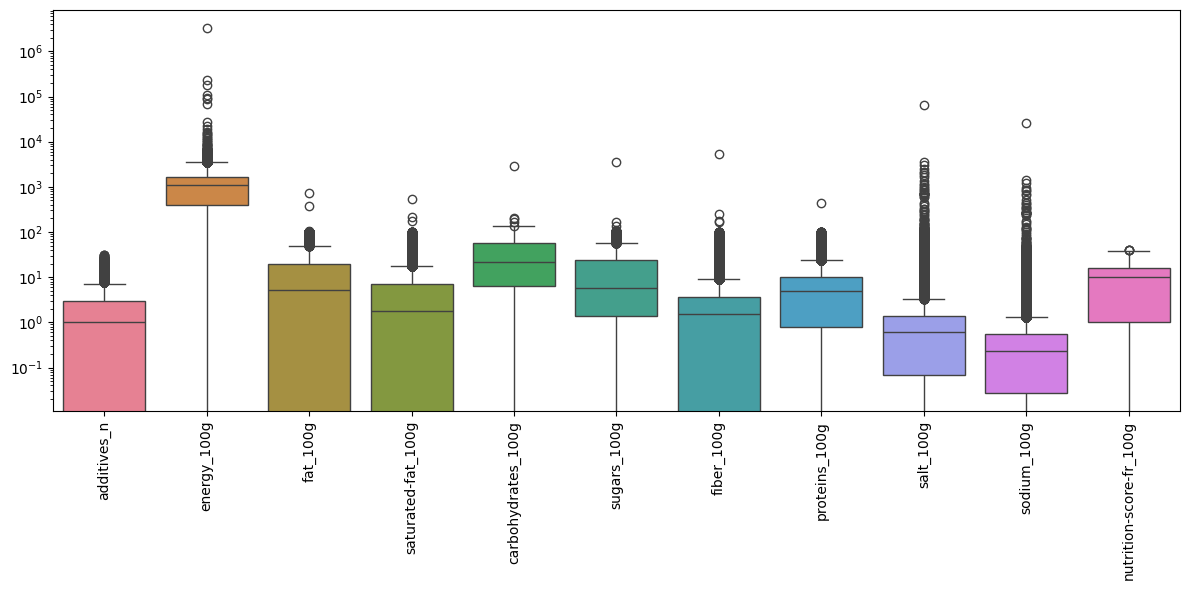

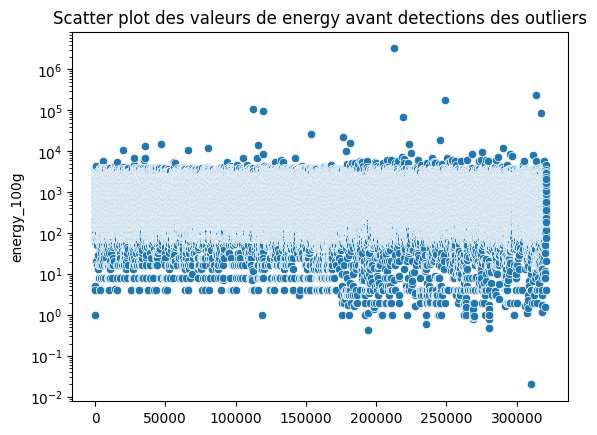

In [ ]:
# Identification des valeurs aberrantes (multi variée)
generate_graph(data=df, graph_type='boxplot' ,log_scale=True)

# Scatter PLot de la colonne energy (uni variée)
sns.scatterplot(data=df['energy_100g'])
plt.title('Scatter plot des valeurs de energy avant detections des outliers')
plt.yscale('log')

c:\Users\vuill\OneDrive\Documents\GitHub\OpenClassrooms\Projet 3 - Préparez des données pour un organisme de santé publique\venv_projet_3\Lib\site-packages\sklearn\impute\_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


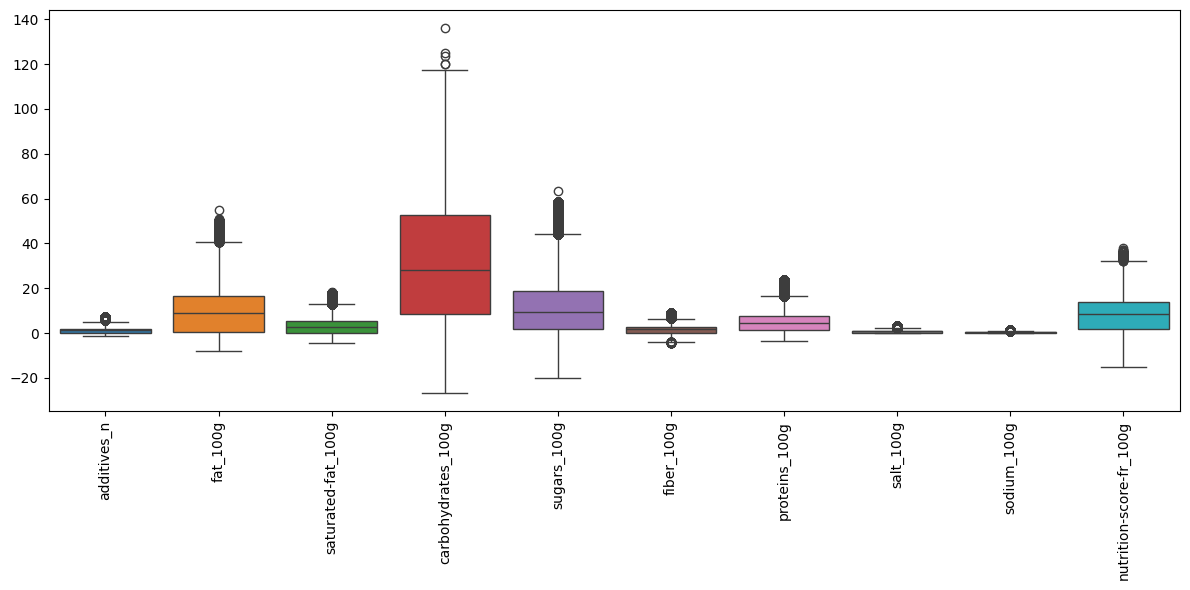

In [ ]:
# Identification et remplacerment des outliers
df = identify_and_replace_outliers(data=df)

# Visualisations des colonnes après remplacements des valeurs manquantes
generate_graph(data=df.drop('energy_100g', axis=1), graph_type='boxplot' ,log_scale=False)

### <a id='toc1_3_5_'></a>[Etape 4 - Analyse uni/bi  variée](#toc0_)

#### <a id='toc1_3_5_1_'></a>[Pie Chart](#toc0_)

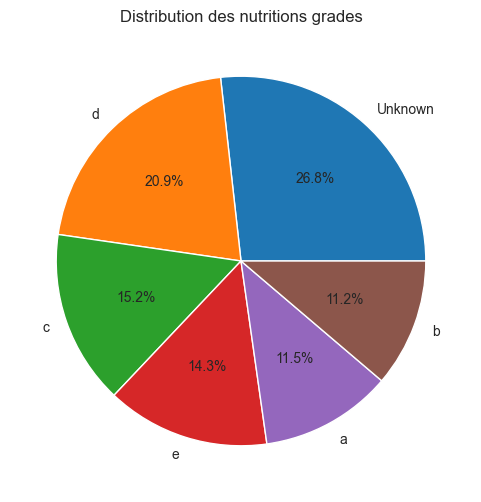

In [ ]:
# pie chart su nutrition grade
generate_graph(data=df, graph_type='pie' ,col='nutrition_grade_fr', title='Distribution des nutritions grades')

#### <a id='toc1_3_5_2_'></a>[Pairplot](#toc0_)

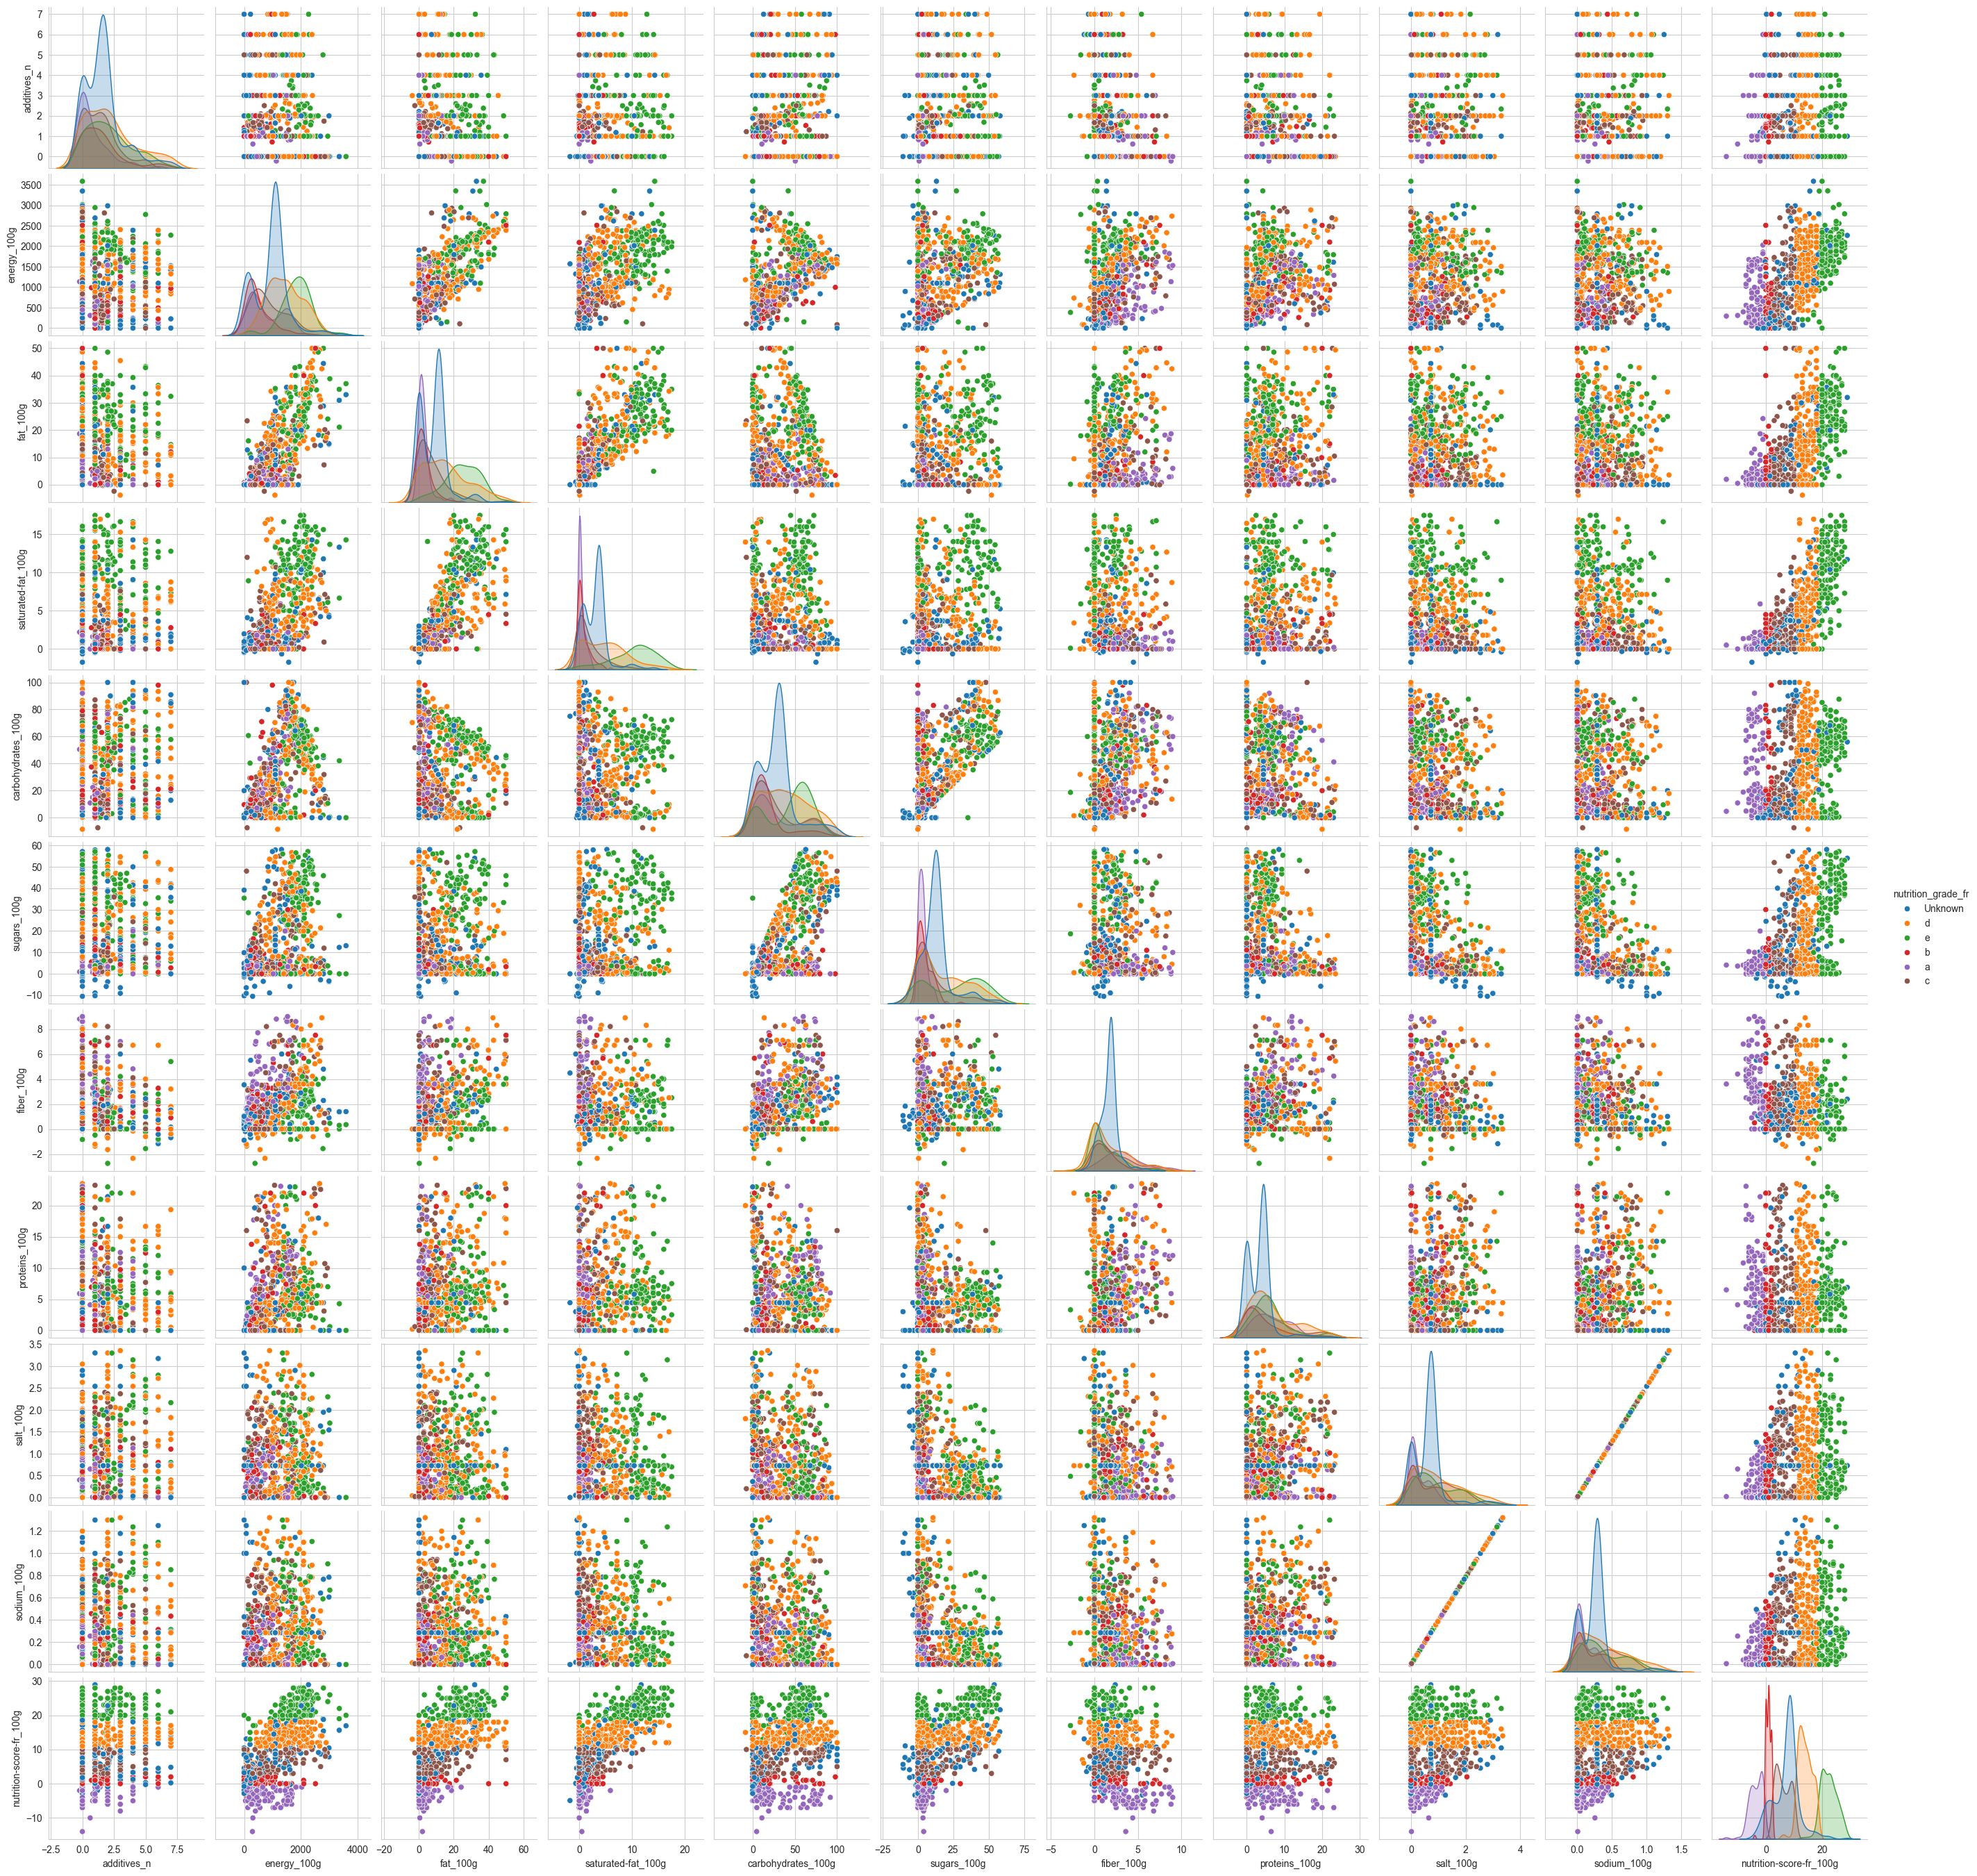

In [ ]:
# Analyse bi-varié multiple grace a la scatter plot matrix
sns.pairplot(df.sample(1000), hue='nutrition_grade_fr')

#### <a id='toc1_3_5_3_'></a>[Matrice de correlation](#toc0_)

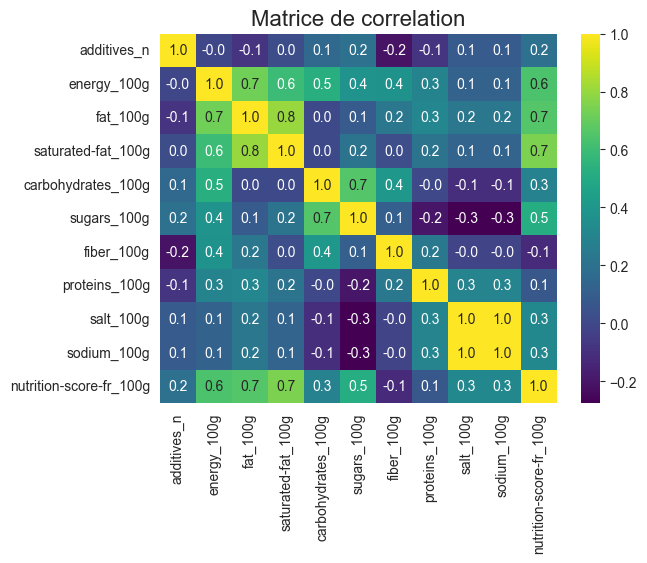

In [ ]:
# Matrice de correlations
generate_graph(data=df, graph_type='corr')

## <a id='toc1_4_'></a>[Analyse en composante principale (PCA)](#toc0_)

In [ ]:
pca_cols = [
            'energy_100g',
            'fat_100g',
            'saturated-fat_100g', 
            'carbohydrates_100g', 
            'sugars_100g', 
            'fiber_100g',
            'proteins_100g', 
            'salt_100g', 
            'sodium_100g',
            ]


### <a id='toc1_4_1_'></a>[Scree plot](#toc0_)

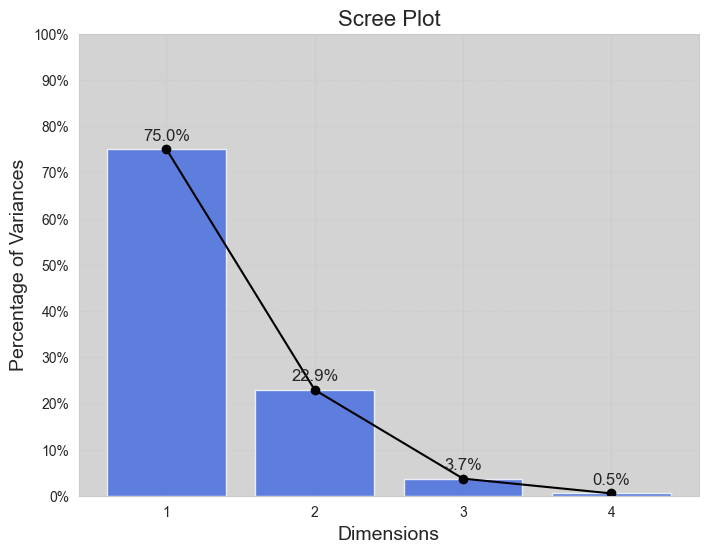

In [ ]:
# Standardize the data
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df[pca_cols].dropna())

# Fit PCA
pca = PCA()
pca.fit(df_scaled)


# Example data
# Assuming pca.explained_variance_ratio_ contains the explained variance ratios
explained_variance = [0.75, 0.229, 0.037, 0.005]  # Replace with actual PCA data
dimensions = range(1, len(explained_variance) + 1)

plt.figure(figsize=(8, 6))
plt.bar(dimensions, explained_variance, color='royalblue', alpha=0.8)
plt.plot(dimensions, explained_variance, marker='o', color='black')

# Adding percentage labels on the bars
for i, v in enumerate(explained_variance):
    plt.text(i + 1, v + 0.02, f"{v*100:.1f}%", ha='center', fontsize=12)

plt.title('Scree Plot', fontsize=16)
plt.xlabel('Dimensions', fontsize=14)
plt.ylabel('Percentage of Variances', fontsize=14)

plt.xticks(dimensions)
plt.yticks(np.arange(0, 1.1, 0.1), [f"{int(y * 100)}%" for y in np.arange(0, 1.1, 0.1)])  # Percentage y-axis
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.gca().set_facecolor('lightgrey')  # Change background color
plt.show()


### <a id='toc1_4_2_'></a>[Cercle des correlation](#toc0_)

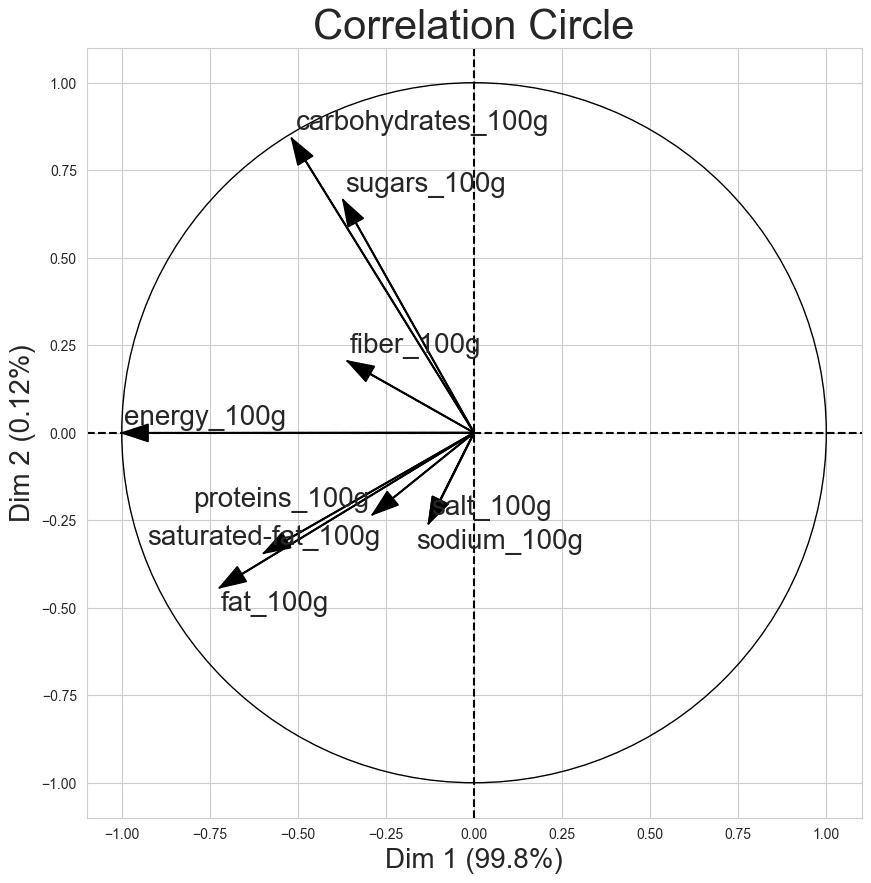

In [ ]:
# Cercle de corr
generate_graph(data=df, graph_type='pca', cols=pca_cols, dimensions=(1,2))


### <a id='toc1_4_3_'></a>[Interpretation des resultats](#toc0_)

Ce cercle de corrélation met en évidence des relations fortes entre certaines variables nutritionnelles, notamment entre les glucides, les sucres et l'énergie, qui jouent un rôle majeur dans la structuration des données (Dim 1). Il montre également des corrélations moins significatives entre certaines variables, comme les protéines et les graisses, qui ne sont pas des contributeurs majeurs à la variance dans ce jeu de données. Dim 1 capte presque toute la structure, ce qui signifie que ces variables sont principalement expliquées par une seule composante.

## <a id='toc1_5_'></a>[ANOVA](#toc0_)

### <a id='toc1_5_1_'></a>[Calcul de l'anova](#toc0_)

In [ ]:
def anova(df, plot, x, y):
    # Recuperations de valeurs numeriques
    numerical_columns = list(df.select_dtypes(include="number").columns)

    # Résultats ANOVA pour chaque colonne numérique
    anova_results = {}
    for col in numerical_columns:
        # Séparer les groupes selon la variable catégorielle
        groups = [df[col][df['nutrition_grade_fr'] == cat] for cat in df['nutrition_grade_fr'].unique()]
        # Appliquer l'ANOVA
        f_val, p_val = stats.f_oneway(*groups)
        anova_results[col] = {'F-value': f_val, 'p-value': p_val}

    if plot:
        generate_graph(df, graph_type='anova', x=x, y=y)
        

    # Afficher les résultats
    return anova_results

### <a id='toc1_5_2_'></a>[Plot de l'anova](#toc0_)

C:\Users\vuill\AppData\Local\Temp\ipykernel_6912\246015973.py:85: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


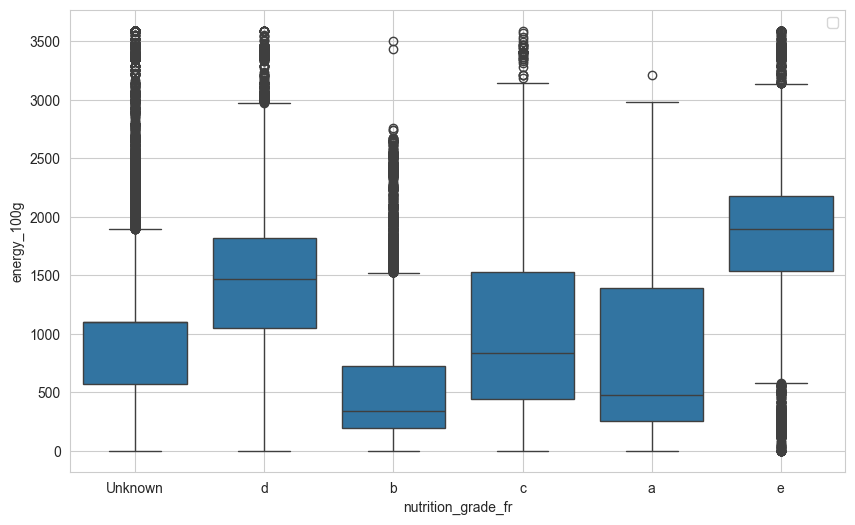

{'additives_n': {'F-value': 2407.599599442256, 'p-value': 0.0}, 'energy_100g': {'F-value': 27177.32589801125, 'p-value': 0.0}, 'fat_100g': {'F-value': 32050.75922001182, 'p-value': 0.0}, 'saturated-fat_100g': {'F-value': 58132.41592206554, 'p-value': 0.0}, 'carbohydrates_100g': {'F-value': 4420.49768213593, 'p-value': 0.0}, 'sugars_100g': {'F-value': 14666.098801717282, 'p-value': 0.0}, 'fiber_100g': {'F-value': 4027.434138759848, 'p-value': 0.0}, 'proteins_100g': {'F-value': 4677.510035650294, 'p-value': 0.0}, 'salt_100g': {'F-value': 5905.006464169827, 'p-value': 0.0}, 'sodium_100g': {'F-value': 5904.999167302364, 'p-value': 0.0}, 'nutrition-score-fr_100g': {'F-value': 318044.08449138503, 'p-value': 0.0}}


In [ ]:
resultat_anova = anova(df, True, 'nutrition_grade_fr', 'energy_100g')
print(resultat_anova)

### <a id='toc1_5_3_'></a>[Interpretation des resultats](#toc0_)

Si on recapitule le json on obtient 

| Variable                             | F-value           | p-value |
|--------------------------------------|-------------------|---------|
| additives_n                          | 2344.95           | 0.0     |
| ingredients_from_palm_oil_n         | 791.87            | 0.0     |
| ingredients_that_may_be_from_palm_oil_n | 306.51        | 0.0     |
| energy_kj                            | 28023.35          | 0.0     |
| fat_100g                             | 18397.22          | 0.0     |
| saturated-fat_100g                  | 34942.42          | 0.0     |
| carbohydrates_100g                  | 4874.44           | 0.0     |
| sugars_100g                         | 11301.89          | 0.0     |
| fiber_100g                          | 3294.61           | 0.0     |
| proteins_100g                       | 2891.05           | 0.0     |
| salt_100g                           | 1011.53           | 0.0     |
| sodium_100g                         | 1011.53           | 0.0     |
| nutrition-score-fr_100g            | 335269.58         | 0.0     |
| nutrition-score-uk_100g            | 244228.88         | 0.0     |

L'analyse de variance (ANOVA) réalisée sur les différentes variables numériques en fonction de la variable catégorielle révèle des résultats significatifs dans tous les cas examinés. Les valeurs F élevées, allant de 306.51 à 335269.58, indiquent que la variance entre les groupes est bien supérieure à la variance au sein des groupes, suggérant des différences marquées dans les moyennes des groupes pour chacune des variables.

De plus, les p-values égales à 0.0 pour toutes les variables analysées indiquent que les différences observées sont statistiquement significatives. Cela signifie que la variable catégorielle a un impact important sur chaque mesure numérique, justifiant ainsi l'importance de la prise en compte de cette variable lors de l'analyse des données.

Les variables relatives aux nutriments tels que nutrition-score-fr_100g et nutrition-score-uk_100g affichent les valeurs F les plus élevées, ce qui pourrait suggérer des disparités significatives dans la qualité nutritionnelle des produits étudiés. Les résultats mettent en évidence des différences claires dans les teneurs en additifs, graisses, sucres, et autres composants, ce qui peut avoir des implications importantes pour les décisions réglementaires, les recommandations de consommation et les stratégies de formulation des produits.

Dans l'ensemble, cette analyse souligne l'importance d'explorer les effets des facteurs catégoriels sur les caractéristiques numériques dans des études de nutrition et de santé publique.

## <a id='toc1_6_'></a>[Respect des RGPD](#toc0_)

| Critères                          | Justifications                                                                                                                                                     |
|-----------------------------------|-------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| **Nature des Données Traitées**   | Le dataset utilisé (openfoodfacts_dataset.csv) contient des informations sur des produits alimentaires (valeurs nutritionnelles, marques, pays, etc.) qui sont généralement anonymisées. |
| **Absence de Données Personnelles**| Les données manipulées ne contiennent pas d'informations personnelles (noms, adresses, numéros de téléphone, identifiants uniques) permettant d'identifier une personne physique.       |
| **Finalité du Traitement**        | L'objectif principal est de nettoyer et préparer des données pour des analyses statistiques et des problématiques métier liées à la santé publique, orienté vers l'amélioration des données au niveau agrégé. |
| **Conformité aux Principes du RGPD** | Bien que le RGPD ne soit pas directement applicable, des bonnes pratiques de gestion des données (minimisation des données, sécurisation des informations) sont respectées.                  |
| **Absence de Consentement et de Base Légale** | Les notions de consentement et de base légale ne s'appliquent pas, car les données ne concernent pas des personnes physiques.                                            |
